In [0]:
import numpy as np
from scipy.spatial.distance import squareform, pdist
import matplotlib.pyplot as plt
from sklearn import datasets

from sklearn.cluster import DBSCAN
from sklearn import metrics

[From Wikipedia](https://en.wikipedia.org/w/index.php?title=DBSCAN&oldid=958031760) the algorithm can be expressed in pseudocode as follows:


```
DBSCAN(DB, distFunc, eps, minPts) {
    C = 0                                                  /* Cluster counter */
    for each point P in database DB {
        if label(P) ≠ undefined then continue              /* Previously processed in inner loop */
        Neighbors N = RangeQuery(DB, distFunc, P, eps)     /* Find neighbors */
        if |N| < minPts then {                             /* Density check */
            label(P) = Noise                               /* Label as Noise */
            continue
        }
        C = C + 1                                          /* next cluster label */
        label(P) = C                                       /* Label initial point */
        Seed set S = N \ {P}                               /* Neighbors to expand */
        for each point Q in S {                            /* Process every seed point */
            if label(Q) = Noise then label(Q) = C          /* Change Noise to border point */
            if label(Q) ≠ undefined then continue          /* Previously processed */
            label(Q) = C                                   /* Label neighbor */
            Neighbors N = RangeQuery(DB, distFunc, Q, eps) /* Find neighbors */
            if |N| ≥ minPts then {                         /* Density check */
                S = S ∪ N                                  /* Add new neighbors to seed set */
            }
        }
    }
}
```
where RangeQuery can be implemented using a database index for better performance, or using a slow linear scan:
```
RangeQuery(DB, distFunc, Q, eps) {
    Neighbors = empty list
    for each point P in database DB {                      /* Scan all points in the database */
        if distFunc(Q, P) ≤ eps then {                     /* Compute distance and check epsilon */
            Neighbors = Neighbors ∪ {P}                    /* Add to result */
        }
    }
    return Neighbors
}
```

In [0]:
class scott_dbscan():
    ''' Homegrown implementation of the DBSCAN algorithm '''

    def __init__(self, points, distance=.1, minpoints=5, distance_metric='euclidean'):
        ''' Do the clustering of points
        Input:  points: a (vector scaled?) array of points to be clustered
                distance: the distance between two points such that 
                they are considered connected
                minpoints: the minimum number of points to define a 
                cluster
                distance_metric: how to measure the distance between points;
                see scipy.spatial.distance.pdist docs '''

        self.points = points 
        self.distance = distance
        self.minpoints = minpoints
        self.distance_metric = distance_metric
        self.cluster_points=[] # points in a cluster
        self.cluster_counter=1 # number of cluster
        self.closest_points=[] # points closest to current point
        self.m=self.points.shape[0] # number of datapoints in points
        self.labels=np.zeros(self.m) # cluster assignment
        self.point_type=np.zeros(self.m) # 1=core, 0=border, -1=noise
        self.seen_already=np.zeros(self.m,'intc') # don't eval points already processed


    def fit(self):
        ''' Perform the clustering of data
        Output: self object '''
        # calc pairwise distancees between points and put into an array
        self.square_matrix = squareform(pdist(self.points, self.distance_metric))
        for i in range(self.m):
            # look only at points not already looked at for clustering purposes
            if self.seen_already[i]==0:
                self.seen_already[i]=1
                # find close points
                self.closest_points=np.where(self.square_matrix[i]<self.distance)[0]
                # if there aren't enough point close by it's a noise point
                if len(self.closest_points)<self.minpoints:
                    self.point_type[i]=-1
                    continue
                else:
                    # add current point to a cluster
                    self.cluster_points.append(i)
                    # label the point with a cluster number
                    self.labels[i]=self.cluster_counter
                    # remove dupes
                    self.closest_points=list(set(self.closest_points))
                    # expand the cluster
                    self.grow_cluster()
                    # fr the current point add all the close neighbors
                    self.cluster_points.append(self.closest_points[:])
                    # start a new cluster label
                    self.cluster_counter+=1
                    
        return self

    def grow_cluster(self):
        ''' Enlarge the cluster around a given point '''
        self.Neighbors=[]

        # scan all points in the database
        for i in self.closest_points:
            # if the point hasn't been seen already
            if self.seen_already[i]==0:
                self.seen_already[i]=1
                self.Neighbors=np.where(self.square_matrix[i]<self.distance)[0]
                # if point is close enough but not in closest_points, add it
                if len(self.Neighbors)>=self.minpoints:
                    for j in self.Neighbors:
                        try:
                            self.closest_points.index(j)
                        except ValueError:
                            self.closest_points.append(j)

            # add points to clusters and cluster labels          
            if self.labels[i]==0:
                self.cluster_points.append(i)
                self.labels[i]=self.cluster_counter
        return self.Neighbors
    
    def fit_predict(self, points, distance=.1, minpoints=5, distance_metric='euclidean'):
        ''' Method that returns the labels (clusters) of the fit method '''
        self.fit()
        return self.labels


In [0]:
x1, y1 = datasets.make_circles(n_samples=1000, factor=0.35, noise=0.04)
x2, y2 = datasets.make_blobs(n_samples=1000, centers=[[0.45, 0.5]], cluster_std=[[0.03]])
x3, y3 = datasets.make_blobs(n_samples=1000, centers=[[-0.45, 0.5]], cluster_std=[[0.03]])

X = np.concatenate((x1, x2, x3))
noise=np.random.rand(50,2)*2-1
Noisy_Data=np.concatenate((X,noise))


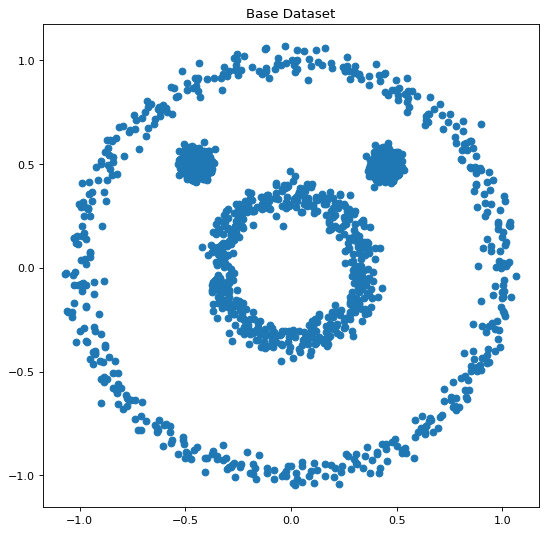

In [4]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(X[:, 0], X[:, 1])
plt.title("Base Dataset")
plt.show
plt.savefig('base_dataset.png')

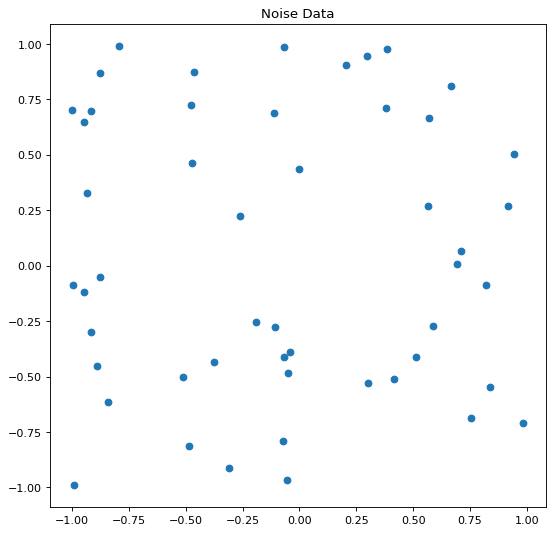

In [5]:
plt.figure(figsize=(8, 8), dpi=80)
plt.title("Noise Data")
plt.scatter(noise[:, 0], noise[:, 1])
plt.show
plt.savefig('noise.png')

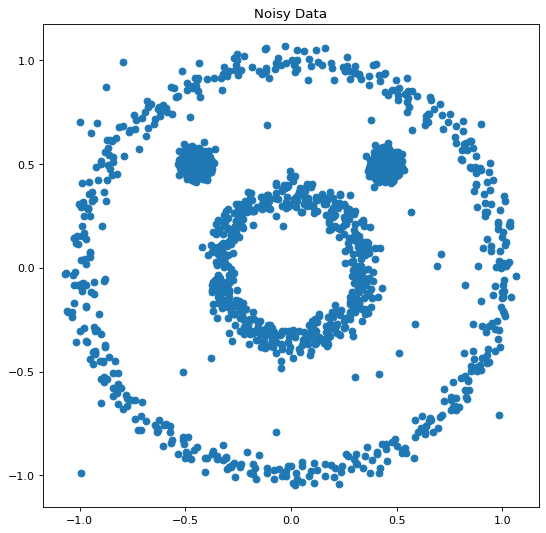

In [6]:
plt.figure(figsize=(8, 8), dpi=80)
plt.title("Noisy Data")
plt.scatter(Noisy_Data[:, 0], Noisy_Data[:, 1])
plt.show
plt.savefig('noisy_dataset.png')

CPU times: user 25.7 s, sys: 174 ms, total: 25.9 s
Wall time: 25.8 s


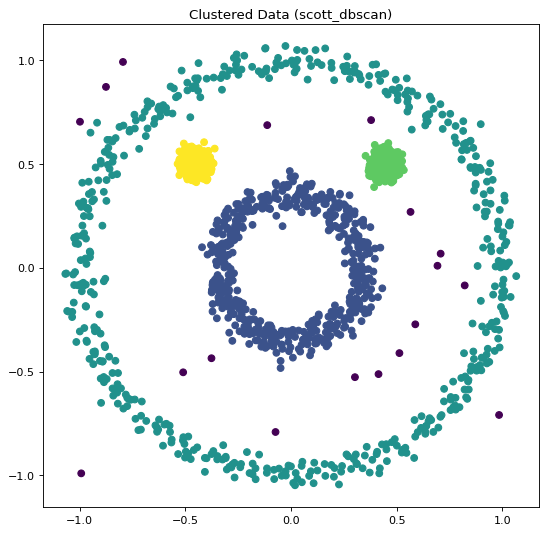

In [7]:
%%time
test=scott_dbscan(Noisy_Data,.1,10, 'euclidean')
output = test.fit_predict(Noisy_Data, .1, 10)
plt.figure(figsize=(8, 8), dpi=80)
plt.title("Clustered Data (scott_dbscan)")
plt.scatter(Noisy_Data[:, 0], Noisy_Data[:, 1], c=output)
plt.show
plt.savefig('clustered_scott_dbscan_dataset.png')

CPU times: user 368 ms, sys: 112 ms, total: 480 ms
Wall time: 350 ms


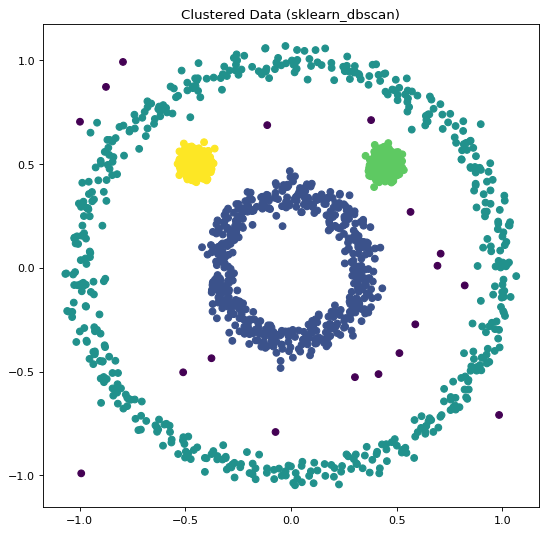

In [8]:
%%time
db = DBSCAN(eps=0.1, min_samples=10).fit(Noisy_Data)
labels = db.labels_
plt.figure(figsize=(8, 8), dpi=80)
plt.title("Clustered Data (sklearn_dbscan)")
plt.scatter(Noisy_Data[:, 0], Noisy_Data[:, 1], c=labels)
plt.show
plt.savefig('clustered_sklearn_dbscan_dataset.png')